In [1]:
import numpy as np
import pandas as pd
import artm
import matplotlib.pyplot as plt
import gc
import os
import pymorphy2
import re
from model import TopicModel

### Global parameters

In [3]:
FULL_PROCESSING = False
SAVE_PROCESSING_DATA = True
LENTA_DATASET_PATH = '../../data/datasets/news_lenta.csv'
PROCESSED_DATASET_PATH = 'processed_data/data_processed.csv'

### Load and prepare data for model

In [ ]:
%%time
tm = TopicModel()

In [4]:
if FULL_PROCESSING:
    data = tm.load_data(LENTA_DATASET_PATH)

    date = tm.get_date(data, column='url')
    data['year'] = date.dt.year
    data['month'] = date.dt.month

    data['docID'] = tm.get_docid(data)
    data['lemmatized_text'] = tm.tokenize_normalize(data['text'])

    if SAVE_PROCESSING_DATA:
        tm.save_data(data, PROCESSED_DATASET_PATH)
else:
    data = tm.load_data(PROCESSED_DATASET_PATH)

[2018-11-08 11:28:14,173] {model.py:37} INFO - Loading data from processed_data/data_processed.csv ...


In [5]:
id_date = tm.get_id_date(data)

In [6]:
%%time
tm.prepare_data_for_model(data=None)

[2018-11-08 11:28:46,028] {model.py:100} INFO - Init BatchVectorizer for data/batches ...
[2018-11-08 11:28:46,029] {model.py:106} INFO - Create from existing batches
[2018-11-08 11:28:46,032] {model.py:112} INFO - Gather dictionary from data/batches ...
CPU times: user 39.4 s, sys: 796 ms, total: 40.2 s
Wall time: 40.9 s


### Filter dictionary

In [7]:
tm.filter_dictionary(min_tf=10, max_df_rate=0.1)

### Init model

In [8]:
%%time
tm.init_model(num_topics=200)

[2018-11-08 11:29:27,486] {model.py:123} INFO - Initializing ARTM model
CPU times: user 2.29 s, sys: 108 ms, total: 2.4 s
Wall time: 2.22 s


### Add scores

In [9]:
scores = ['PerplexityScore', 'SparsityThetaScore', 'SparsityPhiScore', 'TopTokensScore', 'TopicKernelScore']
kwarg_scores = {scorer: {'name': scorer} for scorer in scores}

In [10]:
tm.add_scores(**kwarg_scores)

[2018-11-08 11:29:29,738] {model.py:138} INFO - Scorer PerplexityScore is added to the model
[2018-11-08 11:29:29,740] {model.py:138} INFO - Scorer SparsityThetaScore is added to the model
[2018-11-08 11:29:29,742] {model.py:138} INFO - Scorer SparsityPhiScore is added to the model
[2018-11-08 11:29:29,747] {model.py:138} INFO - Scorer TopTokensScore is added to the model
[2018-11-08 11:29:29,749] {model.py:138} INFO - Scorer TopicKernelScore is added to the model


### Add regularizers

In [11]:
regularizers = {
    'SmoothSparsePhiRegularizer': {'tau': -1.0},
    'SmoothSparseThetaRegularizer': {'tau': -0.5},
    'DecorrelatorPhiRegularizer': {'tau': 1e5}
}

In [12]:
tm.add_regularizers(**regularizers)

[2018-11-08 11:29:29,792] {model.py:161} INFO - Regularizer SmoothSparsePhiRegularizer is added to the model with arguments:
{'tau': -1.0}
[2018-11-08 11:29:29,794] {model.py:161} INFO - Regularizer SmoothSparseThetaRegularizer is added to the model with arguments:
{'tau': -0.5}
[2018-11-08 11:29:29,798] {model.py:161} INFO - Regularizer DecorrelatorPhiRegularizer is added to the model with arguments:
{'tau': 100000.0}


### Fit model

In [13]:
tm.fit_model(num_collection_passes=10)

In [14]:
tm.save_model(force=True)

### Load model

In [15]:
# tm.load_model()

### Metrics

In [16]:
tm.print_measures()

PerplexityScore:  383.517
SparsityThetaScore:  0.934
SparsityPhiScore:  0.975
TopTokensScore:  0.000
TopicKernelScore:  0.000


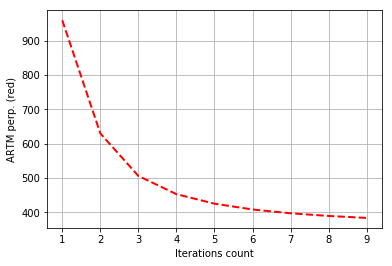

In [17]:
tm.plot_perplexity()

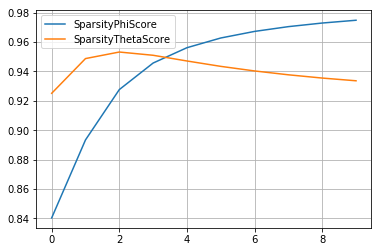

In [18]:
sparse_scores = {}
sparse_scores['SparsityPhiScore'] = tm.model.score_tracker['SparsityPhiScore'].value
sparse_scores['SparsityThetaScore'] = tm.model.score_tracker['SparsityThetaScore'].value
pd.DataFrame(sparse_scores).plot(grid=True)

In [19]:
top_tokens = tm.model.score_tracker['TopTokensScore']
for topic in list(top_tokens.last_tokens.keys())[:20]:
    print(topic, *top_tokens.last_tokens[topic])

topic_0 учёный исследование исследователь журнал клетка университет опубликовать днк анализ автор
topic_1 пост отставка бывший занимать кандидатура уйти должность уход покинуть вица
topic_2 ресторан продукт питание кот еда кошка мясо животное блюдо масло
topic_3 центр форум музей мероприятие культурный открытие культура проект парк открыться
topic_4 кризис помощь миллиард финансовый бюджет программа реформа дефицит мвф план
topic_5 владивосток приморский оркестр гимн композитор яхта приморье край имя концерт
topic_6 бывший арест следствие рубль обвинение мошенничество хищение уголовный деньга сумма
topic_7 извинение высказывание колумбия принести ошибка извиниться журналистка похороны адрес оскорбление
topic_8 театр фестиваль спектакль артист режиссёр актёр постановка сцена опера имя
topic_9 индия индийский нелегальный штат иммигрант аризона слон ферма дели нелегал
topic_10 лебедев адвокат заключённый сизый колония изолятор ходорковский михаил фсин башкирия
topic_11 пользователь сеть с

In [20]:
phi = tm.model.get_phi()
phi['word'] = phi.index

for col in phi.columns[:10]:
    if col != 'word':
        print(col)
        print(phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:20])

topic_0
[('@default_class', 'учёный') ('@default_class', 'исследование')
 ('@default_class', 'исследователь') ('@default_class', 'журнал')
 ('@default_class', 'клетка') ('@default_class', 'университет')
 ('@default_class', 'опубликовать') ('@default_class', 'днк')
 ('@default_class', 'анализ') ('@default_class', 'автор')
 ('@default_class', 'показать') ('@default_class', 'вывод')
 ('@default_class', 'организм') ('@default_class', 'ген')
 ('@default_class', 'мозг') ('@default_class', 'выяснить')
 ('@default_class', 'оказаться') ('@default_class', 'статья')
 ('@default_class', 'использовать') ('@default_class', 'of')]
topic_1
[('@default_class', 'пост') ('@default_class', 'отставка')
 ('@default_class', 'бывший') ('@default_class', 'занимать')
 ('@default_class', 'кандидатура') ('@default_class', 'уйти')
 ('@default_class', 'должность') ('@default_class', 'уход')
 ('@default_class', 'покинуть') ('@default_class', 'вица')
 ('@default_class', 'подать') ('@default_class', 'сенатор')
 ('@def

### Get topics-docs matrix

In [21]:
gb = tm.get_time_topics(id_date)

### PyGal

In [22]:
import pygal
from IPython.display import SVG, HTML

In [23]:
# Эта штука нужна только для того, чтобы в ноутбуке рисовалось
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [24]:
# line_chart = pygal.StackedLine(fill=True, show_dots=False)
# line_chart.title = 'Topics'
# for topic in topics:
#     line_chart.add(topic, gb[topic].values)

# HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

In [32]:
# # Так можно посмотреть большую картинку в отдельной вкладке
# line_chart.render_in_browser()

In [30]:
topics = tm.model.topic_names

In [31]:
from pygal.style import Style

# Если отображать долю, а не абсолютное значение, то становится более читаемо

s = gb[topics].sum(axis=1)
line_chart = pygal.StackedLine(fill=True, show_dots=False,
                               stroke_style={'width': 0.5},
                               style=Style(legend_font_size=6),
                              legend_at_bottom=True)
line_chart.title = 'Topics'
# line_chart.x_labels = map(str, range(2002, 2013))
for topic in topics:
    line_chart.add(topic, gb[topic].values/s)

HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

### Tune num topics

In [33]:
import tqdm

In [34]:
perplexity_values_topics = {}
num_topics_range = [10, 50, 100, 200, 500]
for num_topics in tqdm.tqdm(num_topics_range):
    tm.init_model(num_topics=num_topics)
    
    scores = ['PerplexityScore', 'SparsityThetaScore', 'SparsityPhiScore', 'TopTokensScore', 'TopicKernelScore']
    kwarg_scores = {scorer: {'name': scorer} for scorer in scores}
    tm.add_scores(**kwarg_scores)
    
    regularizers = {
        'SmoothSparsePhiRegularizer': {'tau': -1.0},
        'SmoothSparseThetaRegularizer': {'tau': -0.5},
        'DecorrelatorPhiRegularizer': {'tau': 1e5}
    }
    tm.add_regularizers(**regularizers)
    
    tm.fit_model(num_collection_passes=10)
    
    perplexity_values_topics[num_topics] = tm.model.score_tracker['PerplexityScore'].value
    print(f'Num topics: {num_topics}')
    tm.print_measures()

  0%|          | 0/5 [00:00<?, ?it/s]

[2018-11-09 05:07:03,403] {model.py:123} INFO - Initializing ARTM model
[2018-11-09 05:07:04,375] {model.py:138} INFO - Scorer PerplexityScore is added to the model
[2018-11-09 05:07:04,378] {model.py:138} INFO - Scorer SparsityThetaScore is added to the model
[2018-11-09 05:07:04,379] {model.py:138} INFO - Scorer SparsityPhiScore is added to the model
[2018-11-09 05:07:04,380] {model.py:138} INFO - Scorer TopTokensScore is added to the model
[2018-11-09 05:07:04,381] {model.py:138} INFO - Scorer TopicKernelScore is added to the model
[2018-11-09 05:07:04,383] {model.py:161} INFO - Regularizer SmoothSparsePhiRegularizer is added to the model with arguments:
{'tau': -1.0}
[2018-11-09 05:07:04,385] {model.py:161} INFO - Regularizer SmoothSparseThetaRegularizer is added to the model with arguments:
{'tau': -0.5}
[2018-11-09 05:07:04,387] {model.py:161} INFO - Regularizer DecorrelatorPhiRegularizer is added to the model with arguments:
{'tau': 100000.0}
Num topics: 10
PerplexityScore:  839

 20%|██        | 1/5 [03:23<13:35, 203.97s/it]

TopicKernelScore:  0.000
[2018-11-09 05:10:27,371] {model.py:123} INFO - Initializing ARTM model
[2018-11-09 05:10:28,630] {model.py:138} INFO - Scorer PerplexityScore is added to the model
[2018-11-09 05:10:28,631] {model.py:138} INFO - Scorer SparsityThetaScore is added to the model
[2018-11-09 05:10:28,632] {model.py:138} INFO - Scorer SparsityPhiScore is added to the model
[2018-11-09 05:10:28,633] {model.py:138} INFO - Scorer TopTokensScore is added to the model
[2018-11-09 05:10:28,634] {model.py:138} INFO - Scorer TopicKernelScore is added to the model
[2018-11-09 05:10:28,635] {model.py:161} INFO - Regularizer SmoothSparsePhiRegularizer is added to the model with arguments:
{'tau': -1.0}
[2018-11-09 05:10:28,636] {model.py:161} INFO - Regularizer SmoothSparseThetaRegularizer is added to the model with arguments:
{'tau': -0.5}
[2018-11-09 05:10:28,638] {model.py:161} INFO - Regularizer DecorrelatorPhiRegularizer is added to the model with arguments:
{'tau': 100000.0}
Num topics:

 40%|████      | 2/5 [09:46<14:40, 293.49s/it]

TopicKernelScore:  0.000
[2018-11-09 05:16:50,381] {model.py:123} INFO - Initializing ARTM model
[2018-11-09 05:16:51,923] {model.py:138} INFO - Scorer PerplexityScore is added to the model
[2018-11-09 05:16:51,924] {model.py:138} INFO - Scorer SparsityThetaScore is added to the model
[2018-11-09 05:16:51,925] {model.py:138} INFO - Scorer SparsityPhiScore is added to the model
[2018-11-09 05:16:51,926] {model.py:138} INFO - Scorer TopTokensScore is added to the model
[2018-11-09 05:16:51,928] {model.py:138} INFO - Scorer TopicKernelScore is added to the model
[2018-11-09 05:16:51,929] {model.py:161} INFO - Regularizer SmoothSparsePhiRegularizer is added to the model with arguments:
{'tau': -1.0}
[2018-11-09 05:16:51,931] {model.py:161} INFO - Regularizer SmoothSparseThetaRegularizer is added to the model with arguments:
{'tau': -0.5}
[2018-11-09 05:16:51,932] {model.py:161} INFO - Regularizer DecorrelatorPhiRegularizer is added to the model with arguments:
{'tau': 100000.0}
Num topics:

 60%|██████    | 3/5 [18:28<12:19, 369.65s/it]

TopicKernelScore:  0.000
[2018-11-09 05:25:32,363] {model.py:123} INFO - Initializing ARTM model
[2018-11-09 05:25:34,498] {model.py:138} INFO - Scorer PerplexityScore is added to the model
[2018-11-09 05:25:34,499] {model.py:138} INFO - Scorer SparsityThetaScore is added to the model
[2018-11-09 05:25:34,500] {model.py:138} INFO - Scorer SparsityPhiScore is added to the model
[2018-11-09 05:25:34,501] {model.py:138} INFO - Scorer TopTokensScore is added to the model
[2018-11-09 05:25:34,502] {model.py:138} INFO - Scorer TopicKernelScore is added to the model
[2018-11-09 05:25:34,503] {model.py:161} INFO - Regularizer SmoothSparsePhiRegularizer is added to the model with arguments:
{'tau': -1.0}
[2018-11-09 05:25:34,504] {model.py:161} INFO - Regularizer SmoothSparseThetaRegularizer is added to the model with arguments:
{'tau': -0.5}
[2018-11-09 05:25:34,506] {model.py:161} INFO - Regularizer DecorrelatorPhiRegularizer is added to the model with arguments:
{'tau': 100000.0}
Num topics:

 80%|████████  | 4/5 [32:56<08:14, 494.06s/it]

TopicKernelScore:  0.000
[2018-11-09 05:39:59,649] {model.py:123} INFO - Initializing ARTM model
[2018-11-09 05:40:03,742] {model.py:138} INFO - Scorer PerplexityScore is added to the model
[2018-11-09 05:40:03,744] {model.py:138} INFO - Scorer SparsityThetaScore is added to the model
[2018-11-09 05:40:03,745] {model.py:138} INFO - Scorer SparsityPhiScore is added to the model
[2018-11-09 05:40:03,747] {model.py:138} INFO - Scorer TopTokensScore is added to the model
[2018-11-09 05:40:03,748] {model.py:138} INFO - Scorer TopicKernelScore is added to the model
[2018-11-09 05:40:03,749] {model.py:161} INFO - Regularizer SmoothSparsePhiRegularizer is added to the model with arguments:
{'tau': -1.0}
[2018-11-09 05:40:03,751] {model.py:161} INFO - Regularizer SmoothSparseThetaRegularizer is added to the model with arguments:
{'tau': -0.5}
[2018-11-09 05:40:03,754] {model.py:161} INFO - Regularizer DecorrelatorPhiRegularizer is added to the model with arguments:
{'tau': 100000.0}
Num topics:

100%|██████████| 5/5 [1:05:10<00:00, 782.08s/it]

TopicKernelScore:  0.000


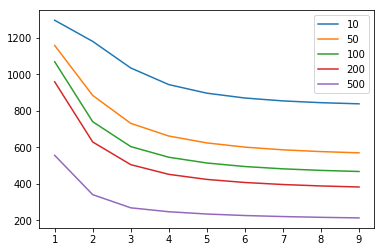

In [35]:
pd.DataFrame(perplexity_values_topics).iloc[1:].plot()

### Tune tau decorrelator

In [36]:
perplexity_values_dec_tau = {}
decorrelator_phi_tau_space = np.geomspace(0.1, 1e7, num=9)
num_topics = 200
for tau in tqdm.tqdm(decorrelator_phi_tau_space):
    tm.init_model(num_topics=num_topics)
    
    scores = ['PerplexityScore', 'SparsityThetaScore', 'SparsityPhiScore', 'TopTokensScore', 'TopicKernelScore']
    kwarg_scores = {scorer: {'name': scorer} for scorer in scores}
    tm.add_scores(**kwarg_scores)
    
    regularizers = {
        'SmoothSparsePhiRegularizer': {'tau': -1.0},
        'SmoothSparseThetaRegularizer': {'tau': -0.5},
        'DecorrelatorPhiRegularizer': {'tau': tau}
    }
    tm.add_regularizers(**regularizers)
    
    tm.fit_model(num_collection_passes=10)
    
    perplexity_values_dec_tau[tau] = tm.model.score_tracker['PerplexityScore'].value
    print(f'Num topics: {num_topics}')
    tm.print_measures()

  0%|          | 0/9 [00:00<?, ?it/s]

[2018-11-09 06:12:14,031] {model.py:123} INFO - Initializing ARTM model
[2018-11-09 06:12:16,209] {model.py:141} INFO - Scorer PerplexityScore is added to the model
[2018-11-09 06:12:16,210] {model.py:141} INFO - Scorer SparsityThetaScore is added to the model
[2018-11-09 06:12:16,211] {model.py:141} INFO - Scorer SparsityPhiScore is added to the model
[2018-11-09 06:12:16,212] {model.py:141} INFO - Scorer TopTokensScore is added to the model
[2018-11-09 06:12:16,213] {model.py:141} INFO - Scorer TopicKernelScore is added to the model
[2018-11-09 06:12:16,215] {model.py:166} INFO - Regularizer SmoothSparsePhiRegularizer is added to the model with arguments:
{'tau': -1.0}
[2018-11-09 06:12:16,216] {model.py:166} INFO - Regularizer SmoothSparseThetaRegularizer is added to the model with arguments:
{'tau': -0.5}
[2018-11-09 06:12:16,218] {model.py:166} INFO - Regularizer DecorrelatorPhiRegularizer is added to the model with arguments:
{'tau': 0.1}
Num topics: 200
PerplexityScore:  384.365

 11%|█         | 1/9 [14:26<1:55:31, 866.44s/it]

TopicKernelScore:  0.000
[2018-11-09 06:26:40,476] {model.py:123} INFO - Initializing ARTM model
[2018-11-09 06:26:42,622] {model.py:141} INFO - Scorer PerplexityScore is added to the model
[2018-11-09 06:26:42,623] {model.py:141} INFO - Scorer SparsityThetaScore is added to the model
[2018-11-09 06:26:42,625] {model.py:141} INFO - Scorer SparsityPhiScore is added to the model
[2018-11-09 06:26:42,626] {model.py:141} INFO - Scorer TopTokensScore is added to the model
[2018-11-09 06:26:42,627] {model.py:141} INFO - Scorer TopicKernelScore is added to the model
[2018-11-09 06:26:42,628] {model.py:166} INFO - Regularizer SmoothSparsePhiRegularizer is added to the model with arguments:
{'tau': -1.0}
[2018-11-09 06:26:42,630] {model.py:166} INFO - Regularizer SmoothSparseThetaRegularizer is added to the model with arguments:
{'tau': -0.5}
[2018-11-09 06:26:42,632] {model.py:166} INFO - Regularizer DecorrelatorPhiRegularizer is added to the model with arguments:
{'tau': 1.0}
Num topics: 200


 22%|██▏       | 2/9 [27:37<1:36:41, 828.77s/it]

TopicKernelScore:  0.000
[2018-11-09 06:39:51,571] {model.py:123} INFO - Initializing ARTM model
[2018-11-09 06:39:53,816] {model.py:141} INFO - Scorer PerplexityScore is added to the model
[2018-11-09 06:39:53,817] {model.py:141} INFO - Scorer SparsityThetaScore is added to the model
[2018-11-09 06:39:53,819] {model.py:141} INFO - Scorer SparsityPhiScore is added to the model
[2018-11-09 06:39:53,820] {model.py:141} INFO - Scorer TopTokensScore is added to the model
[2018-11-09 06:39:53,821] {model.py:141} INFO - Scorer TopicKernelScore is added to the model
[2018-11-09 06:39:53,822] {model.py:166} INFO - Regularizer SmoothSparsePhiRegularizer is added to the model with arguments:
{'tau': -1.0}
[2018-11-09 06:39:53,823] {model.py:166} INFO - Regularizer SmoothSparseThetaRegularizer is added to the model with arguments:
{'tau': -0.5}
[2018-11-09 06:39:53,825] {model.py:166} INFO - Regularizer DecorrelatorPhiRegularizer is added to the model with arguments:
{'tau': 10.0}
Num topics: 200

 33%|███▎      | 3/9 [41:21<1:22:43, 827.32s/it]

TopicKernelScore:  0.000
[2018-11-09 06:53:36,008] {model.py:123} INFO - Initializing ARTM model
[2018-11-09 06:53:38,238] {model.py:141} INFO - Scorer PerplexityScore is added to the model
[2018-11-09 06:53:38,239] {model.py:141} INFO - Scorer SparsityThetaScore is added to the model
[2018-11-09 06:53:38,240] {model.py:141} INFO - Scorer SparsityPhiScore is added to the model
[2018-11-09 06:53:38,241] {model.py:141} INFO - Scorer TopTokensScore is added to the model
[2018-11-09 06:53:38,243] {model.py:141} INFO - Scorer TopicKernelScore is added to the model
[2018-11-09 06:53:38,244] {model.py:166} INFO - Regularizer SmoothSparsePhiRegularizer is added to the model with arguments:
{'tau': -1.0}
[2018-11-09 06:53:38,246] {model.py:166} INFO - Regularizer SmoothSparseThetaRegularizer is added to the model with arguments:
{'tau': -0.5}
[2018-11-09 06:53:38,247] {model.py:166} INFO - Regularizer DecorrelatorPhiRegularizer is added to the model with arguments:
{'tau': 100.0}
Num topics: 20

 44%|████▍     | 4/9 [56:20<1:10:26, 845.21s/it]

TopicKernelScore:  0.000
[2018-11-09 07:08:34,858] {model.py:123} INFO - Initializing ARTM model
[2018-11-09 07:08:37,025] {model.py:141} INFO - Scorer PerplexityScore is added to the model
[2018-11-09 07:08:37,027] {model.py:141} INFO - Scorer SparsityThetaScore is added to the model
[2018-11-09 07:08:37,028] {model.py:141} INFO - Scorer SparsityPhiScore is added to the model
[2018-11-09 07:08:37,028] {model.py:141} INFO - Scorer TopTokensScore is added to the model
[2018-11-09 07:08:37,030] {model.py:141} INFO - Scorer TopicKernelScore is added to the model
[2018-11-09 07:08:37,032] {model.py:166} INFO - Regularizer SmoothSparsePhiRegularizer is added to the model with arguments:
{'tau': -1.0}
[2018-11-09 07:08:37,034] {model.py:166} INFO - Regularizer SmoothSparseThetaRegularizer is added to the model with arguments:
{'tau': -0.5}
[2018-11-09 07:08:37,035] {model.py:166} INFO - Regularizer DecorrelatorPhiRegularizer is added to the model with arguments:
{'tau': 1000.0}
Num topics: 2

 56%|█████▌    | 5/9 [1:10:00<56:00, 840.07s/it]

TopicKernelScore:  0.000
[2018-11-09 07:22:14,382] {model.py:123} INFO - Initializing ARTM model
[2018-11-09 07:22:16,496] {model.py:141} INFO - Scorer PerplexityScore is added to the model
[2018-11-09 07:22:16,498] {model.py:141} INFO - Scorer SparsityThetaScore is added to the model
[2018-11-09 07:22:16,498] {model.py:141} INFO - Scorer SparsityPhiScore is added to the model
[2018-11-09 07:22:16,500] {model.py:141} INFO - Scorer TopTokensScore is added to the model
[2018-11-09 07:22:16,501] {model.py:141} INFO - Scorer TopicKernelScore is added to the model
[2018-11-09 07:22:16,503] {model.py:166} INFO - Regularizer SmoothSparsePhiRegularizer is added to the model with arguments:
{'tau': -1.0}
[2018-11-09 07:22:16,506] {model.py:166} INFO - Regularizer SmoothSparseThetaRegularizer is added to the model with arguments:
{'tau': -0.5}
[2018-11-09 07:22:16,508] {model.py:166} INFO - Regularizer DecorrelatorPhiRegularizer is added to the model with arguments:
{'tau': 10000.0}
Num topics: 

 67%|██████▋   | 6/9 [1:24:22<42:11, 843.79s/it]

TopicKernelScore:  0.000
[2018-11-09 07:36:36,781] {model.py:123} INFO - Initializing ARTM model
[2018-11-09 07:36:39,027] {model.py:141} INFO - Scorer PerplexityScore is added to the model
[2018-11-09 07:36:39,028] {model.py:141} INFO - Scorer SparsityThetaScore is added to the model
[2018-11-09 07:36:39,029] {model.py:141} INFO - Scorer SparsityPhiScore is added to the model
[2018-11-09 07:36:39,030] {model.py:141} INFO - Scorer TopTokensScore is added to the model
[2018-11-09 07:36:39,031] {model.py:141} INFO - Scorer TopicKernelScore is added to the model
[2018-11-09 07:36:39,033] {model.py:166} INFO - Regularizer SmoothSparsePhiRegularizer is added to the model with arguments:
{'tau': -1.0}
[2018-11-09 07:36:39,035] {model.py:166} INFO - Regularizer SmoothSparseThetaRegularizer is added to the model with arguments:
{'tau': -0.5}
[2018-11-09 07:36:39,037] {model.py:166} INFO - Regularizer DecorrelatorPhiRegularizer is added to the model with arguments:
{'tau': 100000.0}
Num topics:

 78%|███████▊  | 7/9 [1:39:02<28:17, 848.89s/it]

TopicKernelScore:  0.000
[2018-11-09 07:51:16,284] {model.py:123} INFO - Initializing ARTM model
[2018-11-09 07:51:18,479] {model.py:141} INFO - Scorer PerplexityScore is added to the model
[2018-11-09 07:51:18,480] {model.py:141} INFO - Scorer SparsityThetaScore is added to the model
[2018-11-09 07:51:18,481] {model.py:141} INFO - Scorer SparsityPhiScore is added to the model
[2018-11-09 07:51:18,484] {model.py:141} INFO - Scorer TopTokensScore is added to the model
[2018-11-09 07:51:18,486] {model.py:141} INFO - Scorer TopicKernelScore is added to the model
[2018-11-09 07:51:18,489] {model.py:166} INFO - Regularizer SmoothSparsePhiRegularizer is added to the model with arguments:
{'tau': -1.0}
[2018-11-09 07:51:18,492] {model.py:166} INFO - Regularizer SmoothSparseThetaRegularizer is added to the model with arguments:
{'tau': -0.5}
[2018-11-09 07:51:18,495] {model.py:166} INFO - Regularizer DecorrelatorPhiRegularizer is added to the model with arguments:
{'tau': 1000000.0}
Num topics

 89%|████████▉ | 8/9 [1:53:31<14:11, 851.45s/it]

TopicKernelScore:  0.000
[2018-11-09 08:05:45,660] {model.py:123} INFO - Initializing ARTM model
[2018-11-09 08:05:47,780] {model.py:141} INFO - Scorer PerplexityScore is added to the model
[2018-11-09 08:05:47,781] {model.py:141} INFO - Scorer SparsityThetaScore is added to the model
[2018-11-09 08:05:47,782] {model.py:141} INFO - Scorer SparsityPhiScore is added to the model
[2018-11-09 08:05:47,784] {model.py:141} INFO - Scorer TopTokensScore is added to the model
[2018-11-09 08:05:47,785] {model.py:141} INFO - Scorer TopicKernelScore is added to the model
[2018-11-09 08:05:47,786] {model.py:166} INFO - Regularizer SmoothSparsePhiRegularizer is added to the model with arguments:
{'tau': -1.0}
[2018-11-09 08:05:47,788] {model.py:166} INFO - Regularizer SmoothSparseThetaRegularizer is added to the model with arguments:
{'tau': -0.5}
[2018-11-09 08:05:47,789] {model.py:166} INFO - Regularizer DecorrelatorPhiRegularizer is added to the model with arguments:
{'tau': 10000000.0}
Num topic

100%|██████████| 9/9 [2:07:52<00:00, 852.50s/it]

TopicKernelScore:  0.000


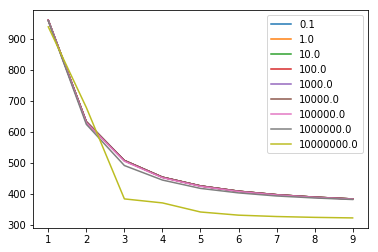

In [37]:
pd.DataFrame(perplexity_values_dec_tau).iloc[1:].plot()